In [575]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

## Data Preparation

In [2]:
path='F:\\Ahsanullah University class topic\SoftComputing Lab\Assignment 3\headlines.csv'
df=pd.read_csv(path,encoding='utf-8-sig')
df.head()

,headline,category,newspaper name
0,"হঠাৎ করে কেঁদে ফেললেন ঐশ্বরিয়া রাই, কেন!",Amusement,Jugantor
1,এত দামি জুতা পরেন প্রিয়াঙ্কা!,Amusement,Jugantor
2,মৃত্যুর আগে শ্রীদেবীর শেষ ভিডিও,Amusement,Jugantor
3,কৌতুক অভিনেতা কপিল শর্মার ঘরে নতুন অতিথি,Amusement,Jugantor
4,বিয়ের পর কোহলির জন্য যে ত্যাগ করলেন আনুশকা,Amusement,Jugantor


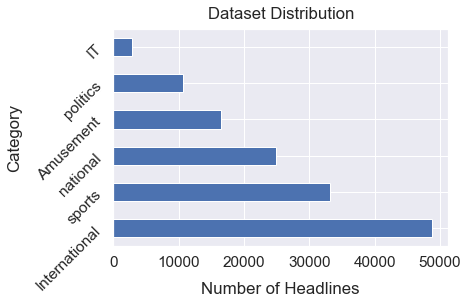

In [3]:
sns.set(font_scale=1.4)
df['category'].value_counts().plot(kind='barh', figsize=(6,4))
plt.xlabel('Number of Headlines', labelpad=12)
plt.ylabel('Category', labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [4]:
df.columns

Index(['headline', 'category', 'newspaper name'], dtype='object')

## Data Cleaning

In [5]:
def cleaning(text):
    headline=re.sub('[^\u0980-\u09FF]',' ',str(text))
    return headline

df['cleaned_headline']=df['headline'].apply(cleaning)

indices=[2500, 3000, 50000, 91000, 100000]
for i in indices:
    print('Original Data--> ',df['headline'][i],'\n', 'Cleaned Data--> ',df['cleaned_headline'][i],'\n','Category--> ',df['category'][i])

Original Data-->  কলকাতার ছবিতেও নিয়মিত অভিনয় করার ইচ্ছা আছে: অপু বিশ্বাস 
 Cleaned Data-->  কলকাতার ছবিতেও নিয়মিত অভিনয় করার ইচ্ছা আছে  অপু বিশ্বাস 
 Category-->  Amusement
Original Data-->  ‘মামা সব মশার জামিন হয়ে গেছে’ 
 Cleaned Data-->   মামা সব মশার জামিন হয়ে গেছে  
 Category-->  Amusement
Original Data-->  তৃতীয়-চতুর্থ শ্রেণির নিয়োগও হবে পিএসসির মাধ্যমে 
 Cleaned Data-->  তৃতীয় চতুর্থ শ্রেণির নিয়োগও হবে পিএসসির মাধ্যমে 
 Category-->  national
Original Data-->  স্বপ্ন সত্যি হলো পন্টিংয়ের 
 Cleaned Data-->  স্বপ্ন সত্যি হলো পন্টিংয়ের 
 Category-->  sports
Original Data-->  কমার্স কলেজের বার্ষিক ক্রীড়া 
 Cleaned Data-->  কমার্স কলেজের বার্ষিক ক্রীড়া 
 Category-->  sports


## Removing Low Length Data

In [6]:
df['Length']=df['cleaned_headline'].apply(lambda x: len(x.split()))
print('Total Headlines: ',len(df))
dataset=df.loc[df.Length>2]
dataset=dataset.reset_index(drop=True)
print('Removed Headlines:  ',len(df)-len(dataset))
print('Total Headlines:  ',len(dataset))

Total Headlines:  136811
Removed Headlines:   4098
Total Headlines:   132713


## Dataset Analysis

In [7]:
class_labels=[k for k,v in dataset['category'].value_counts().to_dict().items()]
    
documents=[]
words=[]
u_words=[]
total_words=[word.strip().lower() for t in list(df['cleaned_headline']) for word in t.strip().split()]

def data_summary(dataset):
    print('Total Words:  {}\n'.format(len(total_words)))
    for label in class_labels:
        words_list = [word for t in dataset[dataset.category==label].cleaned_headline for word in t.strip().split()]
        
        counts=dict()
        for w in words_list:
            counts[w]=counts.get(w,0)+1
        
        ordered=sorted(counts.items(), key=lambda x:x[1], reverse=True)
        
        documents.append(len(list(dataset[dataset.category==label].cleaned_headline)))
        u_words.append(len(np.unique(words_list)))
        words.append(len(words_list))
        
        print('Category:-->{}'.format(label))
        print('Number of documents:-->{}'.format(len(list(dataset[dataset.category==label].cleaned_headline))))
        print('Number of Words:-->{}'.format(len(words_list)))
        print('Number of Unique Words-->{}'.format(len(np.unique(words_list))))
        
        print('Most Unique Words: \n')
        for k,v in ordered[:10]:
            print('{}--->{}'.format(k,v))
        print('\n')
    
    print('Total Unique Words:  {}'.format(len(np.unique(total_words))))

In [8]:
data_summary(dataset)

Total Words:  818161

Category:-->International
Number of documents:-->47885
Number of Words:-->307354
Number of Unique Words-->28710
Most Unique Words: 

নিহত--->3398
না--->2133
নিয়ে--->1634
ট্রাম্প--->1472
মার্কিন--->1434
ও--->1342
থেকে--->1332
ভারতের--->1212
যুক্তরাষ্ট্র--->1208
ভারত--->1192


Category:-->sports
Number of documents:-->30831
Number of Words:-->152852
Number of Unique Words-->18581
Most Unique Words: 

বাংলাদেশ--->1581
না--->1122
জয়--->883
বাংলাদেশের--->873
শুরু--->782
নিয়ে--->689
সাকিব--->672
ভারত--->619
শেষ--->603
দল--->573


Category:-->national
Number of documents:-->24557
Number of Words:-->158042
Number of Unique Words-->20710
Most Unique Words: 

না--->1444
হবে--->1292
ও--->1215
প্রধানমন্ত্রী--->1003
আজ--->752
থেকে--->617
কাদের--->613
খালেদা--->566
বিএনপি--->557
নিয়ে--->556


Category:-->Amusement
Number of documents:-->16067
Number of Words:-->98582
Number of Unique Words-->16622
Most Unique Words: 

নতুন--->1158
নিয়ে--->1074
ও--->1003
গান--->683
ভিডিও--->517


## Summary Visualization

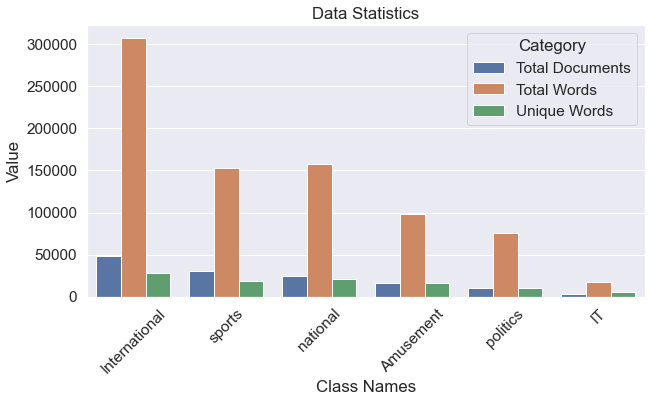

In [9]:
data_matrix=pd.DataFrame({'Total Documents': documents,
                         'Total Words': words,
                         'Unique Words': u_words,
                         'Class Names': class_labels})

d=pd.melt(data_matrix,id_vars='Class Names', var_name='Category', value_name='Value')
plt.figure(figsize=(10,5))
ax=plt.subplot()

sns.barplot(data=d, x='Class Names', y='Value', hue='Category')
ax.set_xlabel('Class Names')
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_labels, rotation=45);

## Headline Length Distribution

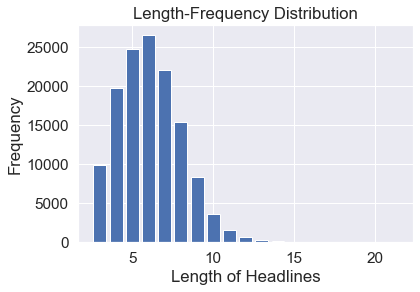

Maximum Length of a headline: 21
Minimum Length of a headline: 3
Average Length of a headline: 6.0


In [10]:
headline_lengths=list(dataset['cleaned_headline'].apply(lambda x:len(x.split())))
frequencies=dict()
for l in headline_lengths:
    frequencies[l]=frequencies.get(l,0)+1

plt.bar(x=frequencies.keys(), height=frequencies.values());
plt.xlabel('Length of Headlines')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a headline: {max(headline_lengths)}")
print(f"Minimum Length of a headline: {min(headline_lengths)}")
print(f"Average Length of a headline: {round(np.mean(headline_lengths),0)}")

## Label Encoding and Dataset Splitting

In [11]:
def label_encoding(category):
    le=LabelEncoder()
    le.fit(category)
    encoded_labels=np.array(le.transform(category))
    
    sample_ids=[1000,98111,12000,5900,89001, 12, 25676, 9876]
    for i in sample_ids:
        print('{}--->{}'.format(category[i], encoded_labels[i]))
    return encoded_labels

In [12]:
labels=label_encoding(dataset.category)

Amusement--->0
sports--->5
politics--->4
IT--->1
sports--->5
Amusement--->0
International--->2
politics--->4


In [202]:
def dataset_splitting(headlines, category):
    X,X_test,y,y_test=train_test_split(headlines, category, train_size=0.9, test_size=0.1, random_state=0)
    X_train, X_valid, y_train, y_valid=train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=0)
    
    print('Dataset Distribution:\n')
    print('\tSet\t\tData')
    print("\t========\t======")
    print('\tTotal:\t\t{}'.format(len(headlines)))
    print('\tTrain:\t\t{}'.format(len(X_train)))
    print('\tTest:\t\t{}'.format(len(X_test)))
    print('\tValid:\t\t{}'.format(len(X_valid)))
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [203]:
X_train,X_valid,X_test,y_train,y_valid,y_test=dataset_splitting(dataset.cleaned_headline, labels)

Dataset Distribution:

	Set		Data
	========	======
	Total:		132713
	Train:		95552
	Test:		13272
	Valid:		23889


In [209]:
X_test.iloc[5900]

'তৃতীয়বারের মতো বিয়ে করলেন ফারজানা ব্রাউনিয়া'

In [210]:
le.inverse_transform([y_test[5900]])

array(['Amusement'], dtype=object)

## Tokenization & Word Embedding (Bengali Glove)

In [29]:
from bnlp import BasicTokenizer
from bnlp import BengaliGlove
import codecs

In [35]:
basic_tokenizer=BasicTokenizer()
basic_tokenizer.tokenize(X_train[12818])

['যশোর', '৫', 'মনিরামপুরে', 'নৌকার', 'পক্ষে', 'লাভলুর', 'শোডাউন']

In [28]:
glove_path = "Bengali NLP Embedding/bn_glove.39M.300d.txt"
word = "গ্রাম"
bng = BengaliGlove()
bng.word2vec(glove_path, word).shape

(300,)

In [82]:
def load_glove_model(glove_file):
    f = open(glove_file, 'r', encoding='utf-8')
    model = {}
    for line in f:
        split_line = line.split()
        word = split_line[0]
        embedding = np.array([float(val) for val in split_line[1:]])
        model[word] = embedding
    return model

In [83]:
glove_300d=load_glove_model('Bengali NLP Embedding/bn_glove.39M.300d.txt')

In [265]:
def embed_text(text):
    lst=[]
    lst_pad=[[0]*300]*21

    words=basic_tokenizer.tokenize(text) 
      
    n=len(words)
  
    for t in words:
        try:
            embedded=list(glove_300d[t])
            lst.append(embedded)
        except:
            lst.append(list(np.random.rand(300)))
    
    lst_pad[:n]=lst
    embedding=np.array(lst_pad)

    embedding=torch.from_numpy(embedding)
    embedding=embedding.float()

    return embedding,n

In [266]:
embed_text(X_train.iloc[90790])

(tensor([[-0.4217, -0.1609,  0.0702,  ...,  0.4581,  0.4871, -0.1652],
         [-0.3777,  0.8339, -0.4069,  ...,  0.0384,  0.6182, -0.1282],
         [ 0.1703,  0.2032,  0.6650,  ...,  0.7410,  0.5693,  0.5794],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 5)

In [267]:
le=LabelEncoder()
le.fit(dataset['category'])
le.classes_

array(['Amusement', 'IT', 'International', 'national', 'politics',
       'sports'], dtype=object)

In [268]:
le.inverse_transform([y_train[90790]])

array(['International'], dtype=object)

## Dataset Creation

In [269]:
import torch.utils.data as data

In [376]:
class NewsHeadlineDataset(data.Dataset):
    def __init__(self, headline, label):
        super(NewsHeadlineDataset, self).__init__()
        
        self.headlines=list(headline)
        self.labels=label
        
    def __len__(self):
        return len(self.headlines)
    
    def __getitem__(self, idx):
        h=self.headlines[idx]
        a=self.labels[idx]
        
        #print('Headline:  ',h)
        embedding,n=embed_text(h)
        #print('Length:    ',n)
        #print('Answer: ',le.inverse_transform([a]))
        
        return embedding,n,a

In [377]:
train_set=NewsHeadlineDataset(X_train,y_train)
train_set.__getitem__(100)

(tensor([[-0.1279,  0.1105, -0.0578,  ...,  0.0695,  0.0996, -0.1803],
         [ 0.4081,  0.0382, -0.5042,  ...,  0.2732, -0.4717, -0.3955],
         [ 0.1562,  0.3349, -0.7114,  ...,  0.0854, -0.7943, -0.3885],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 7,
 5)

In [378]:
valid_set=NewsHeadlineDataset(X_valid,y_valid)
valid_set.__getitem__(1)

(tensor([[ 0.3642,  0.5048,  0.8728,  ...,  0.3411,  0.1621,  0.2830],
         [-0.5983, -0.2389, -0.2803,  ..., -0.4920,  0.4673,  0.2201],
         [-0.0654,  0.1253, -0.3436,  ..., -0.7648,  0.3672, -0.3848],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 9,
 4)

In [379]:
test_set=NewsHeadlineDataset(X_test,y_test)
test_set.__getitem__(1)

(tensor([[-0.1469,  0.0466,  0.1638,  ...,  0.0936,  0.0732,  0.0603],
         [ 0.1160,  0.1137, -0.1367,  ...,  0.2021, -0.1933, -0.1186],
         [-0.5998, -0.3847,  0.2584,  ...,  0.0764,  0.3469,  0.2975],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 4,
 5)

In [472]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Model Definition

In [475]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_size, num_layers):
        super(LSTM, self).__init__()
        
        self.embedding_dim=embedding_dim
        self.hidden_dim=hidden_dim
        self.num_layers=num_layers
        self.output_size=output_size
        
        self.lstm=nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional=False, batch_first=True)
        
        self.fc=nn.Linear(hidden_dim, output_size)
        
        self.dropout=nn.Dropout(0.5)
        self.relu=nn.ReLU()
        
    def forward(self, embedding, n):
        h0 = torch.zeros(self.num_layers, embedding.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, embedding.size(0), self.hidden_dim).to(device)
    
        out,_=self.lstm(embedding, (h0,c0))
        
        out=self.fc(out[:,-1,:])
        
        return out

In [477]:
from torchsummary import summary
model=LSTM(embedding_dim=300,hidden_dim=512,output_size=6,num_layers=1).to(device)
model

LSTM(
  (lstm): LSTM(300, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

## Hyperparameters

In [478]:
learning_rate=0.001
batch=256
epoch=10

optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion=nn.CrossEntropyLoss()

## Model Training

In [479]:
train_loader=DataLoader(dataset=train_set, batch_size=batch, shuffle=True)
valid_loader=DataLoader(dataset=valid_set, batch_size=batch, shuffle=True)
test_loader=DataLoader(dataset=test_set, batch_size=batch)

In [480]:
train_loss=[]
train_acc=[]
valid_loss=[]
valid_acc=[]
prev_acc=0.0

print('<-----------------Start Training------------------->')
for ep in range(epoch):
    model.train()
    num_updates, accuracy, loss_=0.0,0.0,0.0
    v_acc, v_loss, v_count=0.0,0.0,0.0
    for i,m,n in train_loader:
        embedding=i.to(device)
        seq_len=m.to(device)
        label=n.to(device)

        model.zero_grad()
        output=model(embedding,seq_len)
        _,pred=torch.max(output,1)

        loss=criterion(output,label.long()) 
        loss.backward()
        optimizer.step()
        
        accuracy+=torch.sum(pred==label)
        loss_+=loss.item()
        
        num_updates+=1
        
    train_loss.append(loss_/(num_updates))
    train_acc.append(accuracy/(num_updates*batch))
    
    print('Epoch {}--> Loss: {}   Accuracy: {}'.format(ep,(loss_/(num_updates)),(accuracy/(num_updates*batch))))
    
    
    with torch.no_grad():
        model.eval()
        for embedd, seq, ans in valid_loader:
            op=model(embedd.to(device),seq.to(device))
            _,ypred=torch.max(op,1)

            l=criterion(op,ans.long().to(device))

            v_acc+=torch.sum(ypred==ans.to(device))
            v_loss+=l.item()

            v_count+=1
    
    valid_loss.append(v_loss/(v_count))
    valid_acc.append(v_acc/(v_count*batch))
    
    print('\t\tValidation Loss:  {}  Validation Accuracy:  {}'.format((v_loss/(v_count)),(v_acc/(v_count*batch))))
        
print('<-----------------Finished Training------------------->')

<-----------------Start Training------------------->
Epoch 0--> Loss: 0.8197503800698143   Accuracy: 0.6888787150382996
		Validation Loss:  0.5948783603120358  Validation Accuracy:  0.7840341925621033
Epoch 1--> Loss: 0.5384210269240772   Accuracy: 0.8019092679023743
		Validation Loss:  0.5132399781587276  Validation Accuracy:  0.8062666058540344
Epoch 2--> Loss: 0.4691705499740845   Accuracy: 0.8261092305183411
		Validation Loss:  0.48010195189333976  Validation Accuracy:  0.8171957731246948
Epoch 3--> Loss: 0.42085326809615375   Accuracy: 0.8407315611839294
		Validation Loss:  0.4659390909240601  Validation Accuracy:  0.8235538005828857
Epoch 4--> Loss: 0.37377106764896667   Accuracy: 0.8594794869422913
		Validation Loss:  0.47052545845508575  Validation Accuracy:  0.8256316184997559
Epoch 5--> Loss: 0.3347771058187765   Accuracy: 0.8733811378479004
		Validation Loss:  0.4544187549580919  Validation Accuracy:  0.8307845592498779
Epoch 6--> Loss: 0.2902273285516443   Accuracy: 0.89108

In [523]:
torch.save(model.state_dict(), 'Model_trained_News_Headline.pth')

In [524]:
train_accuracy=[]
for t in train_acc:
    train_accuracy.append(t.to('cpu'))
valid_accuracy=[]
for t in valid_acc:
    valid_accuracy.append(t.to('cpu'))

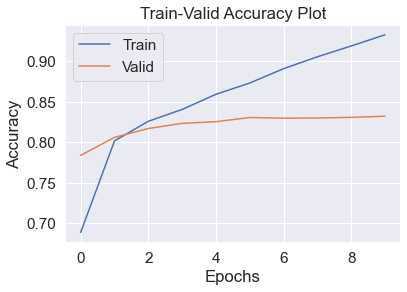

In [525]:
import matplotlib.pyplot as plt
epochs_=[]
for i in range(10):
    epochs_.append(i)
plt.plot(epochs_,train_accuracy,label='Train')
plt.plot(epochs_,valid_accuracy,label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train-Valid Accuracy Plot')
plt.legend()
plt.show()

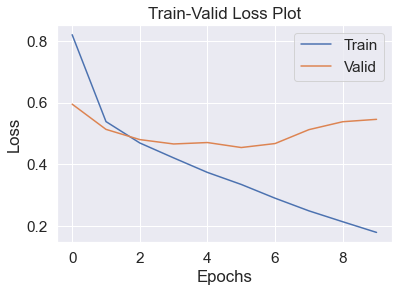

In [526]:
import matplotlib.pyplot as plt
epochs_=[]
for i in range(10):
    epochs_.append(i)
plt.plot(epochs_,train_loss,label='Train')
plt.plot(epochs_,valid_loss,label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train-Valid Loss Plot')
plt.legend()
plt.show()

## Model Testing

In [583]:
test_labels=[]
predicted_labels=[]

with torch.no_grad():
    test_acc, test_loss, test_count=0.0,0.0,0.0
    model.eval()
    for embedd, seq, ans in test_loader:
        op=model(embedd.to(device),seq.to(device))
        _,ypred=torch.max(op,1)
        
        test_labels.extend(ans)
        predicted_labels.extend(ypred)

        l=criterion(op,ans.long().to(device))

        test_acc+=torch.sum(ypred==ans.to(device))
        test_loss+=l.item()

        test_count+=1
    
    test_accuracy=test_acc/(test_count*batch)
    test_loss_score=test_loss/(test_count)
    
    print('\033[1m Test Loss:  {0:0.4f}  Test Accuracy:  {1:0.4f} \033[0;0m'.format((test_loss_score),(test_accuracy)))

 Test Loss:  0.5579  Test Accuracy:  0.8334 


## Result Analysis

In [584]:
test_seq_labels=[]
for k in range(len(test_labels)):
    test_seq_labels.append(test_labels[k].to('cpu').item())

pred_seq_labels=[]
for k in range(len(predicted_labels)):
    pred_seq_labels.append(predicted_labels[k].to('cpu').item())

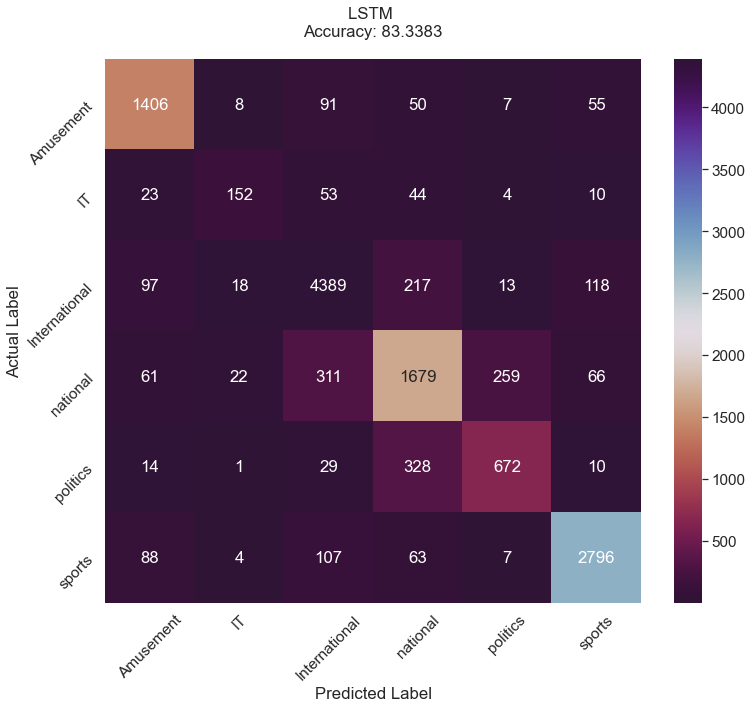

In [586]:
cm=confusion_matrix(test_seq_labels, pred_seq_labels)
cm_df=pd.DataFrame(cm, index=['Amusement', 'IT', 'International', 'national', 'politics','sports'],
                  columns=['Amusement', 'IT', 'International', 'national', 'politics','sports'])

plt.figure(figsize=(12,10))
sns.heatmap(cm_df, annot=True,fmt='g',cmap="twilight_shifted_r")
plt.title('LSTM \nAccuracy: {0:.4f}\n'.format(test_accuracy*100))
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [590]:
report = pd.DataFrame(classification_report(y_true = test_seq_labels, y_pred = pred_seq_labels, output_dict=True)).transpose()
report = report.rename(index={'0': 'Amusement','1':'IT','2':'International','3':'National','4':'Politics','5':'Sports'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

,precision,recall,f1-score,support
Amusement,83.24,86.95,85.06,1617.000000
IT,74.15,53.15,61.91,286.000000
International,88.13,90.46,89.28,4852.000000
National,70.52,70.02,70.27,2398.000000
Politics,69.85,63.76,66.67,1054.000000
Sports,91.52,91.22,91.37,3065.000000
accuracy,83.59,83.59,83.59,0.835895
macro avg,79.57,75.93,77.43,13272.000000
weighted avg,83.38,83.59,83.43,13272.000000
